In [26]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely
import vaex
import h3
from shapely import wkt
from sklearn.preprocessing import TargetEncoder
from sklearn.svm import LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import local_helpers as lh

# Dataset preparation
We first need to aggregate all taxi trips per hour per pickup location in order to obtain a dataset which can be used to predict demand. We define the demand for a given hour, let's say 3pm, as all the rides which have a timestamp between 3.00 - 3.59pm. Thereby we only aggregate those with the same pickup location.

In [27]:
# This functions loads the dataset either with hexagons or census tract
def load_dataset_to_pandas(resolution=10, location_type_hexagon = True):
    df = vaex.open('./data/trips_prepared.hdf5')
    df.head()

    df["trip_start_day"] = df.trip_start_timestamp.dt.day
    df["trip_start_month"] = df.trip_start_timestamp.dt.month
    df["trip_start_hour"] = df.trip_start_timestamp.dt.hour
    df["trip_start_minute"] = df.trip_start_timestamp.dt.minute

    if location_type_hexagon:
        
        
    
        RESOLUTION = resolution
        def geo_to_h3(row1, row2):
            return h3.geo_to_h3(row1,row2, RESOLUTION)

        # Step 1: For each pickup and drop-off calculate the correct hexagon in the resolution
        df['pickup_loc'] = df.apply(geo_to_h3, [df['pickup_centroid_latitude'], df['pickup_centroid_longitude']])
    else:
        df.rename('pickup_census_tract', 'pickup_loc')

    df_demand = df.groupby(['trip_start_hour', 'trip_start_month', 'trip_start_day', 'pickup_loc']).agg({'demand': 'count'})
    # Add timestamp as preparation for resampling
    df_demand['timestamp'] = pd.to_datetime({'year': 2017, 'month': df_demand['trip_start_month'].to_numpy(), 'day': df_demand['trip_start_day'].to_numpy(), 'hour': df_demand['trip_start_hour'].to_numpy()}).to_numpy()

    df_demand = df_demand.to_pandas_df()
    return df_demand


## Hourly Resampling
Handling time series data often requires consistent intervals. In our dataset, not all pickup areas have rides in every hour of the year. As a result, certain hours might be missing in the dataframe for some locations.

### Solution
To ensure that each pickup location has an hourly time series over the entire year, we'll address the missing data in the following way:

**Identify Missing Hours:** Determine the hours that lack data for each pickup location.

**Insert Missing Rows:** For each missing hour, insert a new row in the dataframe.
Fill Demand with Zero: In the newly inserted rows, we'll set the demand to 0, indicating a lack of demand in those specific hours.
By following this approach, we can create a complete and consistent hourly representation of the demand across all pickup locations for the entire year.

In [28]:
def resample_to_hourly(df):
    start_date = '2017-01-01 00:00:00'
    end_date = '2017-12-31 23:00:00'
    hourly_range = pd.date_range(start=start_date, end=end_date, freq='H')
    num_entries_per_year = len(hourly_range)
    hour_range = np.tile(hourly_range.hour,len(np.unique(df.pickup_loc)))
    month_range = np.tile(hourly_range.month,len(np.unique(df.pickup_loc)))
    day_range = np.tile(hourly_range.day,len(np.unique(df.pickup_loc)))
    hourly_range = np.tile(hourly_range,len(np.unique(df.pickup_loc)))

    data = {
        'trip_start_hour': hour_range,
        'trip_start_month': month_range,
        'trip_start_day': day_range,
        'pickup_loc': np.repeat(np.unique(df.pickup_loc), num_entries_per_year),
        'demand': 0,
    }

    df_hourly = pd.DataFrame(data, index=hourly_range)
    df_hourly= df_hourly.set_index([df_hourly.index, 'pickup_loc'])

    df=df.set_index(['timestamp', 'pickup_loc'])

    df_hourly.update(df)

    df_hourly=df_hourly.reset_index()
    df_hourly.columns = ['timestamp','pickup_loc','trip_start_hour','trip_start_month','trip_start_day','demand']
    return df_hourly
    

# Feature Engineering

In order to build powerful models, we have to come up with features that help predicting demand patterns. During feature engineering, we use important insights, we obtained from the descriptive analysis, such insights on the relationship between demand and time or weather condition. 

## Target Feature
It is a requirement to predict the cummulative demand for the time horizons 1, 2, 6, and 24 hours. Hence we need to construct 4 different features which will be later used as a target.

In [29]:
def get_target_time_bucket_demand(df):
    
    demand_cols = [f'demand_n-{num}' for num in list(range(0,25))]
    
    for shift in list(range(0,25)):
        df[f'demand_n-{shift}'] =  df.sort_values('timestamp').groupby('pickup_loc')['demand'].shift((-1)*shift)
        
    two_hours = ['demand_n-0','demand_n-1']
    six_hours = [f'demand_n-{num}' for num in list(range(0,6))]
    twentyfour_hours = [f'demand_n-{num}' for num in list(range(0,24))]
    
    df['demand_target_bucket_1'] = df['demand_n-0']
    df['demand_target_bucket_2'] = df[two_hours].sum(axis=1)
    df['demand_target_bucket_6'] = df[six_hours].sum(axis=1)
    df['demand_target_bucket_24'] = df[twentyfour_hours].sum(axis=1)
    df = df.drop(labels=demand_cols, axis=1)
       
    
    return df

## Previous demand as input

As we have given time series data, it is a common approach to use the demand of previous hours (or days etc.) as an input for the prediction. The assumption we hereby make is that the factors that influence the demand have not changed dramatically within the used time frames. We have decided to construct the following features from previous demand:

* 2 hour: The asssumption is that the demand should not change dramatically between two hours.
* 24 hours: The asssumption is that the current demand should be comparable to the demand exactly one day ago, as factors such as season, time of the day are the same.

In [30]:
def get_past_single_hour_demand(df):
    df['demand_h-2'] = df.sort_values('timestamp').groupby('pickup_loc')['demand'].shift(2)
    df['demand_h-24'] = df.sort_values('timestamp').groupby('pickup_loc')['demand'].shift(24)
    return df

We also construct features that are the cummulative past demand:
* `demand_bucket_2`: Cumulative demand over two hours starting from the current hour the day before
* `demand_bucket_6`: Cumulative demand over six hours starting from the current hour the day before
* `demand_bucket_24`: Cumulative demand over 24 hours starting form the current hour the day before

In [31]:
def get_past_time_bucket_demand(df):
    
    demand_cols = [f'demand_p-{num}' for num in list(range(0,24))]
    
    for shift in list(range(0,25)):
        df[f'demand_p-{shift}'] =  df.sort_values('timestamp').groupby('pickup_loc')['demand'].shift(shift)
        
    two_hours = ['demand_p-24', 'demand_p-23']
    six_hours = [f'demand_p-{num}' for num in list(range((24-5),25))]
    twentyfour_hours = [f'demand_p-{num}' for num in list(range(1,25))]
    
    df['demand_bucket_2'] = df[two_hours].sum(axis=1)
    df['demand_bucket_6'] = df[six_hours].sum(axis=1)
    df['demand_bucket_24'] = df[twentyfour_hours].sum(axis=1)
    df = df.drop(labels=demand_cols, axis=1)
    
    
    
    return df

## Weather features
In the descriptive analysis, particularly the analysis of temporal demand patterns, we found that the temperature and demand curves follow similar directions. Therefore, we construct features based on temperature to enable models that capture this relationship.

### Include weather data
First, we have to include the weather data into the dataframe. For this we just need to merge the two datasets, as both are already in hourly frequency. The weather data contains data for minute 53 of an hour. Therefore, we round up to the nearest hour for each row. We suppose that the weather changes in seven minutes can be disregarded.

**Condition Features:** The weather data contains a categorical columns which states the weather condition. We aggregate the conditions and do One hot encoding.

In [32]:
def weather_categories(weather):
    if "Fair" in weather:
        return "Clear/Sunny"
    elif "Cloudy" in weather:
        return "Cloudy"
    elif "Rain" in weather or "Drizzle" in weather or "T-Storm" in weather or "Thunder" in weather:
        return "Rain/Storms"
    elif "Snow" in weather or "Wintry" in weather:
        return "Snow/Winter Conditions"
    elif weather in ["Fog", "Haze", "Smoke", "Widespread Dust / Windy"]:
        return "Other"
    else:
        return "Miscellaneous"
    
def merge_weather(df):
    # read and merge weather data
    df_weather = pd.read_csv('data/weather_data_final.csv')
    df_weather['date_time'] = pd.to_datetime(df_weather['date_time'])
    df_weather['date_time'] = df_weather['date_time'].dt.ceil('H')
    df_weather.rename(columns={'date_time': 'timestamp'}, inplace=True)

    # cast data types
    df_weather['temp'] = df_weather['temp'].str.replace('\xa0°F', '').astype(float).fillna(np.nan)
    df_weather['dew_point'] = df_weather['dew_point'].str.replace('\xa0°F', '').astype(float).fillna(np.nan)
    df_weather['humidity'] = df_weather['humidity'].str.replace('\xa0°%', '').astype(float).fillna(np.nan)
    df_weather['wind_speed'] = df_weather['wind_speed'].str.replace('\xa0°mph', '').astype(float).fillna(np.nan)
    df_weather['wind_gust'] = df_weather['wind_gust'].str.replace('\xa0°mph', '').astype(float).fillna(np.nan)
    df_weather['pressure'] = df_weather['pressure'].str.replace('\xa0°in', '').astype(float).fillna(np.nan)
    df_weather['precip'] = df_weather['precip'].str.replace('\xa0°in', '').astype(float).fillna(np.nan)
    df_weather = df_weather.drop(['time','date', 'dew_point'], axis=1)
    df_weather['condition'] = df_weather["condition"].apply(weather_categories)
    
    dummies = pd.get_dummies(df_weather['condition']).astype(int)
    df_weather = pd.concat([df_weather.drop(['condition'], axis=1), dummies], axis=1)
    df = df.merge(df_weather, on='timestamp', how='left')
    return df

### Temperature features
In addition to the current temperature, we add the temperature from hour prior to the time of taxi demand. We suggest that this temperature might have led to the decision to call a taxi at the current time

In [33]:
def get_past_temperature(df):
    df['temp_h-1'] = df.sort_values('timestamp').groupby('pickup_loc')['temp'].shift(1)
    return df

### Precipitation
We hypothesize that precipitation has a significant impact on demand. Therefore, we construct features that describe whether it has rained in the last 1-2 hours.

In [34]:
def get_past_precip(df):
    df['precip_h-1'] = df.sort_values('timestamp').groupby('pickup_loc')['precip'].shift(1)
    df['precip_h-2'] = df.sort_values('timestamp').groupby('pickup_loc')['precip'].shift(2)
    return df

## Time Features

### Season
The descriptive analysis has shwon that there is a small seasonality in the data. Hence, we constructed feature which indicates the current season and one hot encoded it.

In [35]:
def date_to_season(date):
    if pd.Timestamp(2017, 12, 22) <= date or date < pd.Timestamp(2017, 3, 20):
        return 'winter'
    elif pd.Timestamp(2017, 3, 20) <= date < pd.Timestamp(2017, 6, 21):
        return 'spring'
    elif pd.Timestamp(2017, 6, 21) <= date < pd.Timestamp(2017, 9, 23):
        return 'summer'
    else:
        return 'autumn'

def get_season(df):
    # Vectorize the date_to_season function
    date_to_season_vec = np.vectorize(date_to_season)
    
    # Apply the vectorized function to the 'timestamp' column
    df['season'] = date_to_season_vec(df['timestamp'])
    
    # Create dummies
    dummies = pd.get_dummies(df['season']).astype(int)
    df = pd.concat([df.drop(['season'], axis=1), dummies], axis=1)    
    return df

### Weekend feature
In the descriptive analysis we have seen that demand changes depending on weekend or not. Hence we engineer a feature "weekend" which is 1 for all rides on saturday & sunday and zero for all other days.

In [36]:
def get_weekend(df):
    df['weekend'] = (df['timestamp'].dt.weekday >= 5).astype(int)
    return df

### Daytime features
In addition, descriptive analysis has shown that the time of day, i.e., whether it is night, morning, afternoon, or evening, plays an important role in determining demand. Therefore, we developed four characteristics, each indicating whether a trip occurs during the following times.
* Morning: 6 a.m. - 12 p.m.
* Afternoon: 12 noon - 6 p.m.
* Evening: 6 p.m. - 11 p.m.
* Night: 12 a.m. - 6 a.m.

In [37]:
def get_pnt_day_with_pnt_week(dt):
    dt = pd.to_datetime(dt)  
    time_of_week = "week" if dt.weekday() < 5 else "weekend"
    hour = dt.hour

    if 6 <= hour < 12:
        return "morning_" + time_of_week
    elif 12 <= hour < 18:
        return "afternoon_" + time_of_week
    elif 18 <= hour < 23:
        return "evening_" + time_of_week
    else:
        return "night_" + time_of_week

def get_daytime(df):
    vfunc = np.vectorize(get_pnt_day_with_pnt_week)
    df['daytime'] = vfunc(df['timestamp'])
    dummies = pd.get_dummies(df['daytime']).astype(int)
    df = pd.concat([df.drop(['daytime'], axis=1), dummies], axis=1)
    return df


### Event Features
Events such as public holidays might influence the demand. In order to capture these patterns we introduce the public holiday feature

There were several public holidays in Boston:
* Martin Luther King Day: Monday, January 16, 2017
* Lincoln's Birthday: Monday, February 13, 2017
* Washington's Birthday (President's Day): Monday, February 20, 2017
* Memorial Day: Monday, May 29, 2017
* Independence Day: Tuesday, July 04, 2017
* Labor Day: Monday, September 04, 2017
* Columbus Day: Monday, October 09, 2017
* Veterans' Day: Friday, November 10, 2017
* Thanksgiving Day: Thursday, November 23, 2017
* Thanksgiving Day: Friday, November 24, 2017
* Christmas Day: Monday, December 25, 2017

These events might have influenced the demand

In [38]:
holiday_dates = [
    datetime(2017, 1, 2),   # New Year's Day
    datetime(2017, 1, 16),  # Martin Luther King Day
    datetime(2017, 2, 13),  # Lincoln's Birthday
    datetime(2017, 2, 20),  # Washington's Birthday (President's Day)
    datetime(2017, 5, 29),  # Memorial Day
    datetime(2017, 7, 4),   # Independence Day
    datetime(2017, 9, 4),   # Labor Day
    datetime(2017, 10, 9),  # Columbus Day
    datetime(2017, 11, 10), # Veterans' Day
    datetime(2017, 11, 23), # Thanksgiving Day
    datetime(2017, 11, 24), # Day after Thanksgiving
    datetime(2017, 12, 25), # Christmas Day
]

def get_holiday_dates(df):
    df['is_holiday'] = df['timestamp'].isin(holiday_dates).astype(int)
    return df

## Point of Interest Features
We have also retrieved point of interest data and found out that areas with many points of interests have higher taxi demand. Hence we also include also PoI features by introducing categories of PoIs.

* Catering: cafe, fast_food, food_court, restaurant, supermarket
* Transportation: bicycle_parking, bus_station, taxi, railway_stations, airports
* Entertainment: arts_centre, brothel, cinema, conference_centre, events_venue, music_venue, nightclub, stripclub, swingerclub, theatre, bar, pub
* Healthcare: clinic, dentist, doctors, hospital, pharmacy

For each spatial unit we count the number of PoIs for each category. Moreover we construct a `poi_sum` feature, which sums up all the PoIs of all categories.

In [39]:
def get_poi_data(df, resolution, hexagon=True):
    
    if hexagon:
        df_poi = pd.read_csv(f'./data/poi_output_v2/hexagons_res_{resolution}.csv')
    else:
        df_poi = pd.read_csv(f'./data/poi_output_v2/census_tracts.csv')
        df_mapping = pd.read_csv(f'./data/chicago_census_tracts.csv')
        df_poi = df_poi.merge(df_mapping[['NAMELSAD10', 'GEOID10']], left_on='id', right_on='NAMELSAD10', how='left')
        df_poi['id'] = df_poi['GEOID10']
        df_poi.drop(columns=['NAMELSAD10', 'GEOID10'], inplace=True)

    df_poi = df_poi[['id', 'catering', 'entertainment', 'transportation', 'healthcare']]
    df_merged = df.merge(df_poi, left_on='pickup_loc', right_on='id', how='left')

    df_merged.drop(columns=['id'], inplace=True)
    df_merged['poi_sum'] = df_merged[['catering', 'entertainment', 'transportation', 'healthcare']].sum(axis=1)

    return df_merged

### Prepare dataset helpers
The following function loads the dataset and automatically engineers the previously described features

In [40]:
def get_prepared_data(location_type_hexagon=True, resolution=10):
    df = load_dataset_to_pandas(location_type_hexagon=location_type_hexagon, resolution=resolution)
    
    df = resample_to_hourly(df)
    df = merge_weather(df)
    df = get_past_temperature(df)
    df = get_past_precip(df)
    df = get_season(df)
    df = get_weekend(df)
    df = get_daytime(df)    
    df = get_holiday_dates(df)
    df = get_past_single_hour_demand(df)
    df = get_past_time_bucket_demand(df)    
    df = get_target_time_bucket_demand(df)    
    df = get_poi_data(df, resolution, location_type_hexagon)
    
    return df

# Correlation Analysis


We have different measurement scales:

Ordinal (natural order, but no quantifiable difference between values or binary):
- season_x 
- trip_start_hour
- trip_start_month
- trip_start_day
Metric (equidistant scale):
- temp
- demand
- precipitation
- humidity
- wind_speed
- wind_gust
- pressure
Nominal:
- public_holiday
- weekend
- condition_Clear/Sunny etc.

We do 2 different analysis:
- Metric <-> Metric (Pearson)
- Ordinal <-> Metric, Nominal <-> Metric (Spearman)

In [41]:
df_res_5 = get_prepared_data(True, 5)

In [ ]:

# continuous variables
metric = ['temp', 'humidity', 'wind_speed', 'wind_gust', 'pressure', 'precip', 'temp_h-1', 'temp_h-2', 'temp_h-3', 'precip_h-1', 'precip_h-2', 'precip_h-3', 'demand', 'demand_h-2', 'demand_h-24', 'demand_p-24', 'catering', 'transportation', 'healthcare', 'entertainment', 'poi_sum']

# categorical without ranking
nominal = ['Clear/Sunny', 'Cloudy', 'Other', 'Rain/Storms', 'Snow/Winter Conditions', 'autumn', 'spring', 'summer', 'winter', 'weekend', 'afternoon_week', 'afternoon_weekend', 'evening_week', 'evening_weekend', 'morning_week', 'morning_weekend', 'night_week', 'night_weekend', 'is_holiday']

# categories that can be ranked, but the distances between rank values are not uniform
ordinal = ['trip_start_hour', 'trip_start_month', 'trip_start_day']

<Axes: >

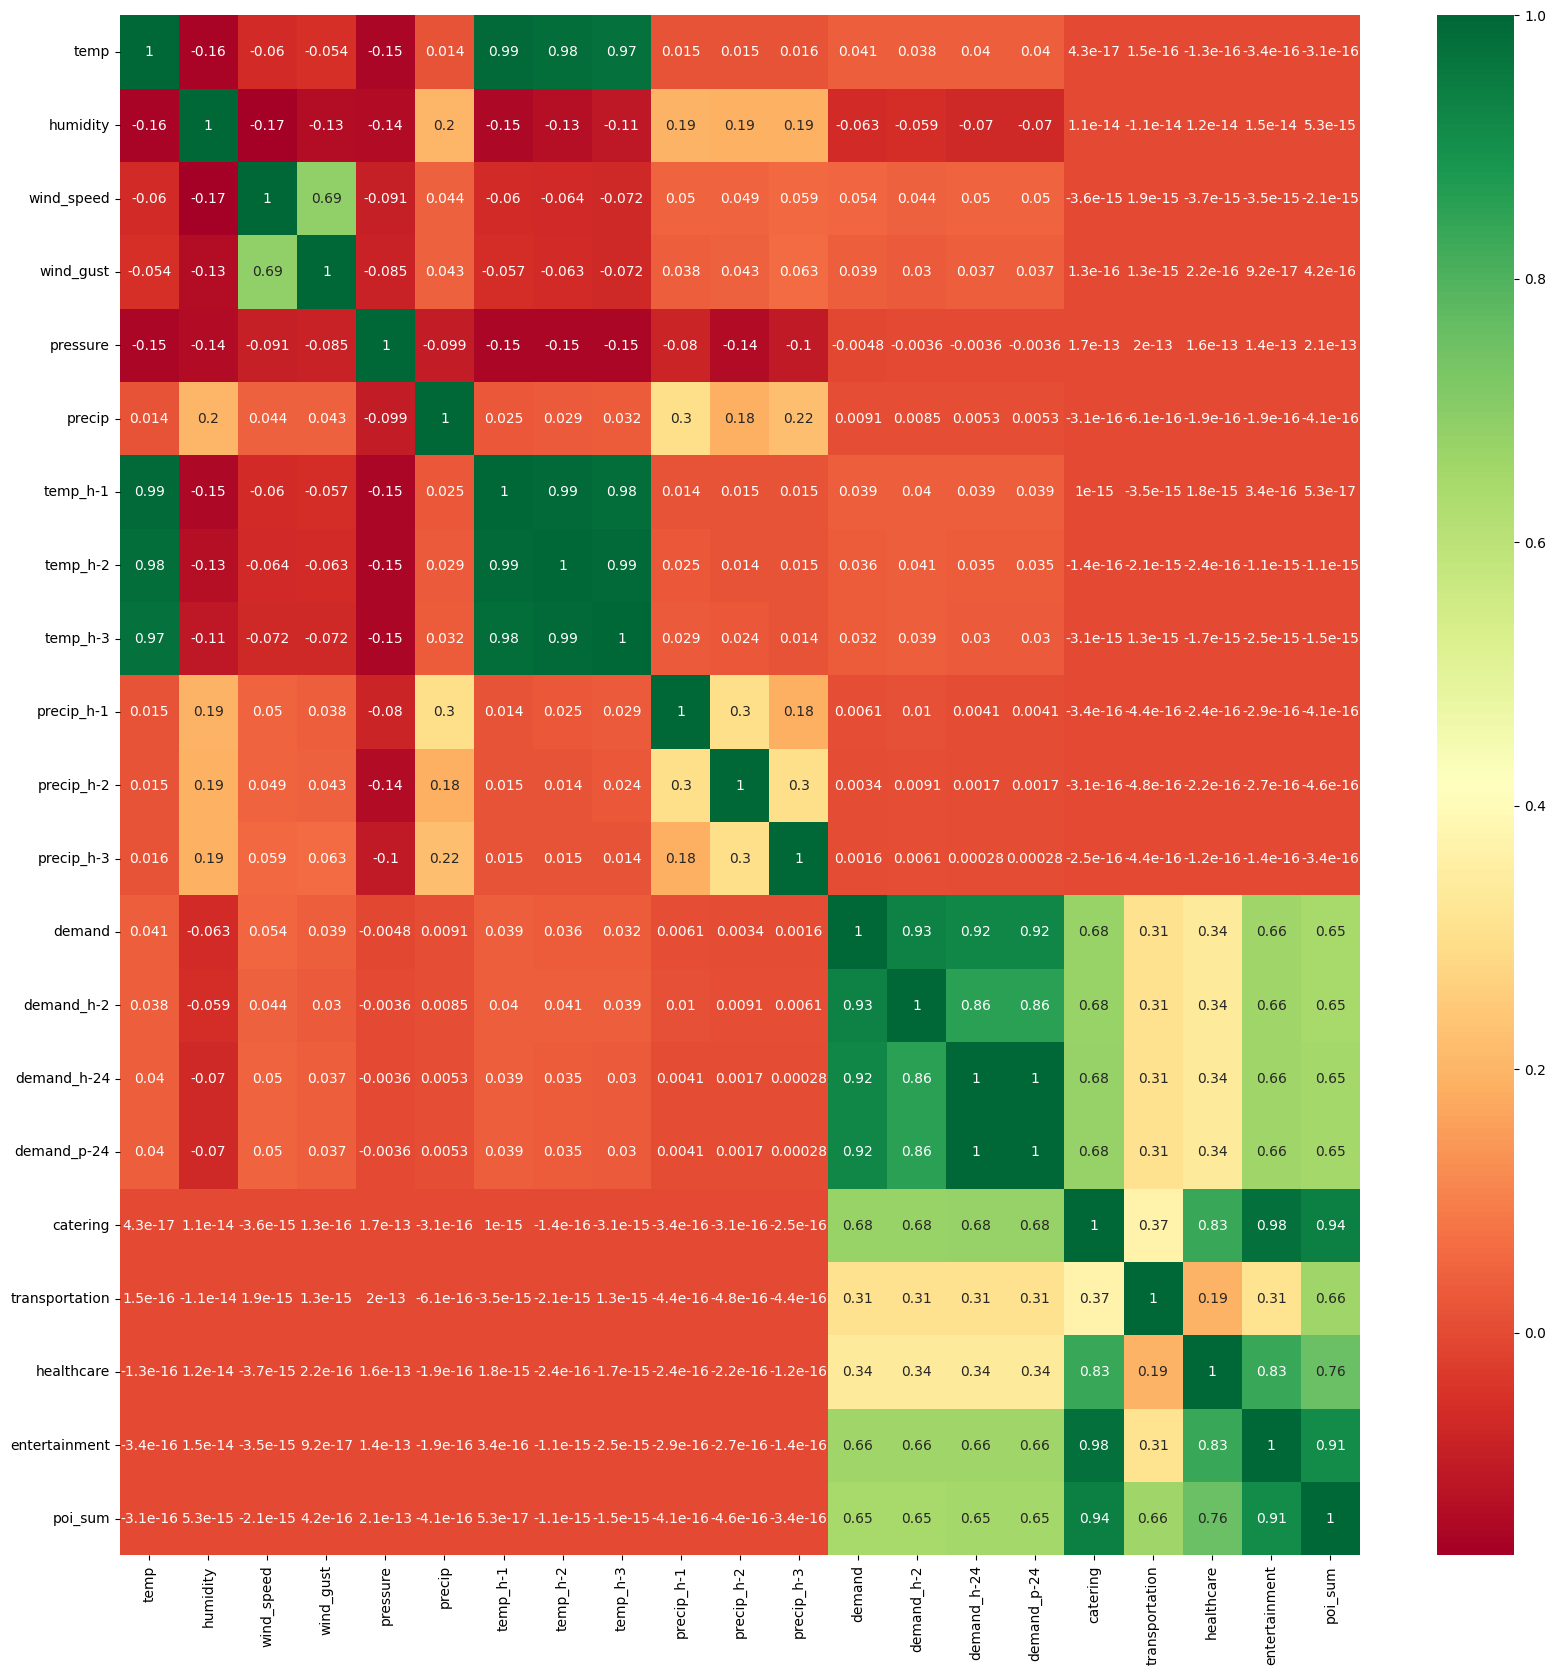

In [ ]:
metric = df_res_5[metric]
plt.figure(figsize=(20, 20))
sns.heatmap(metric.corr(method="pearson"), annot=True, cmap="RdYlGn")

<Axes: >

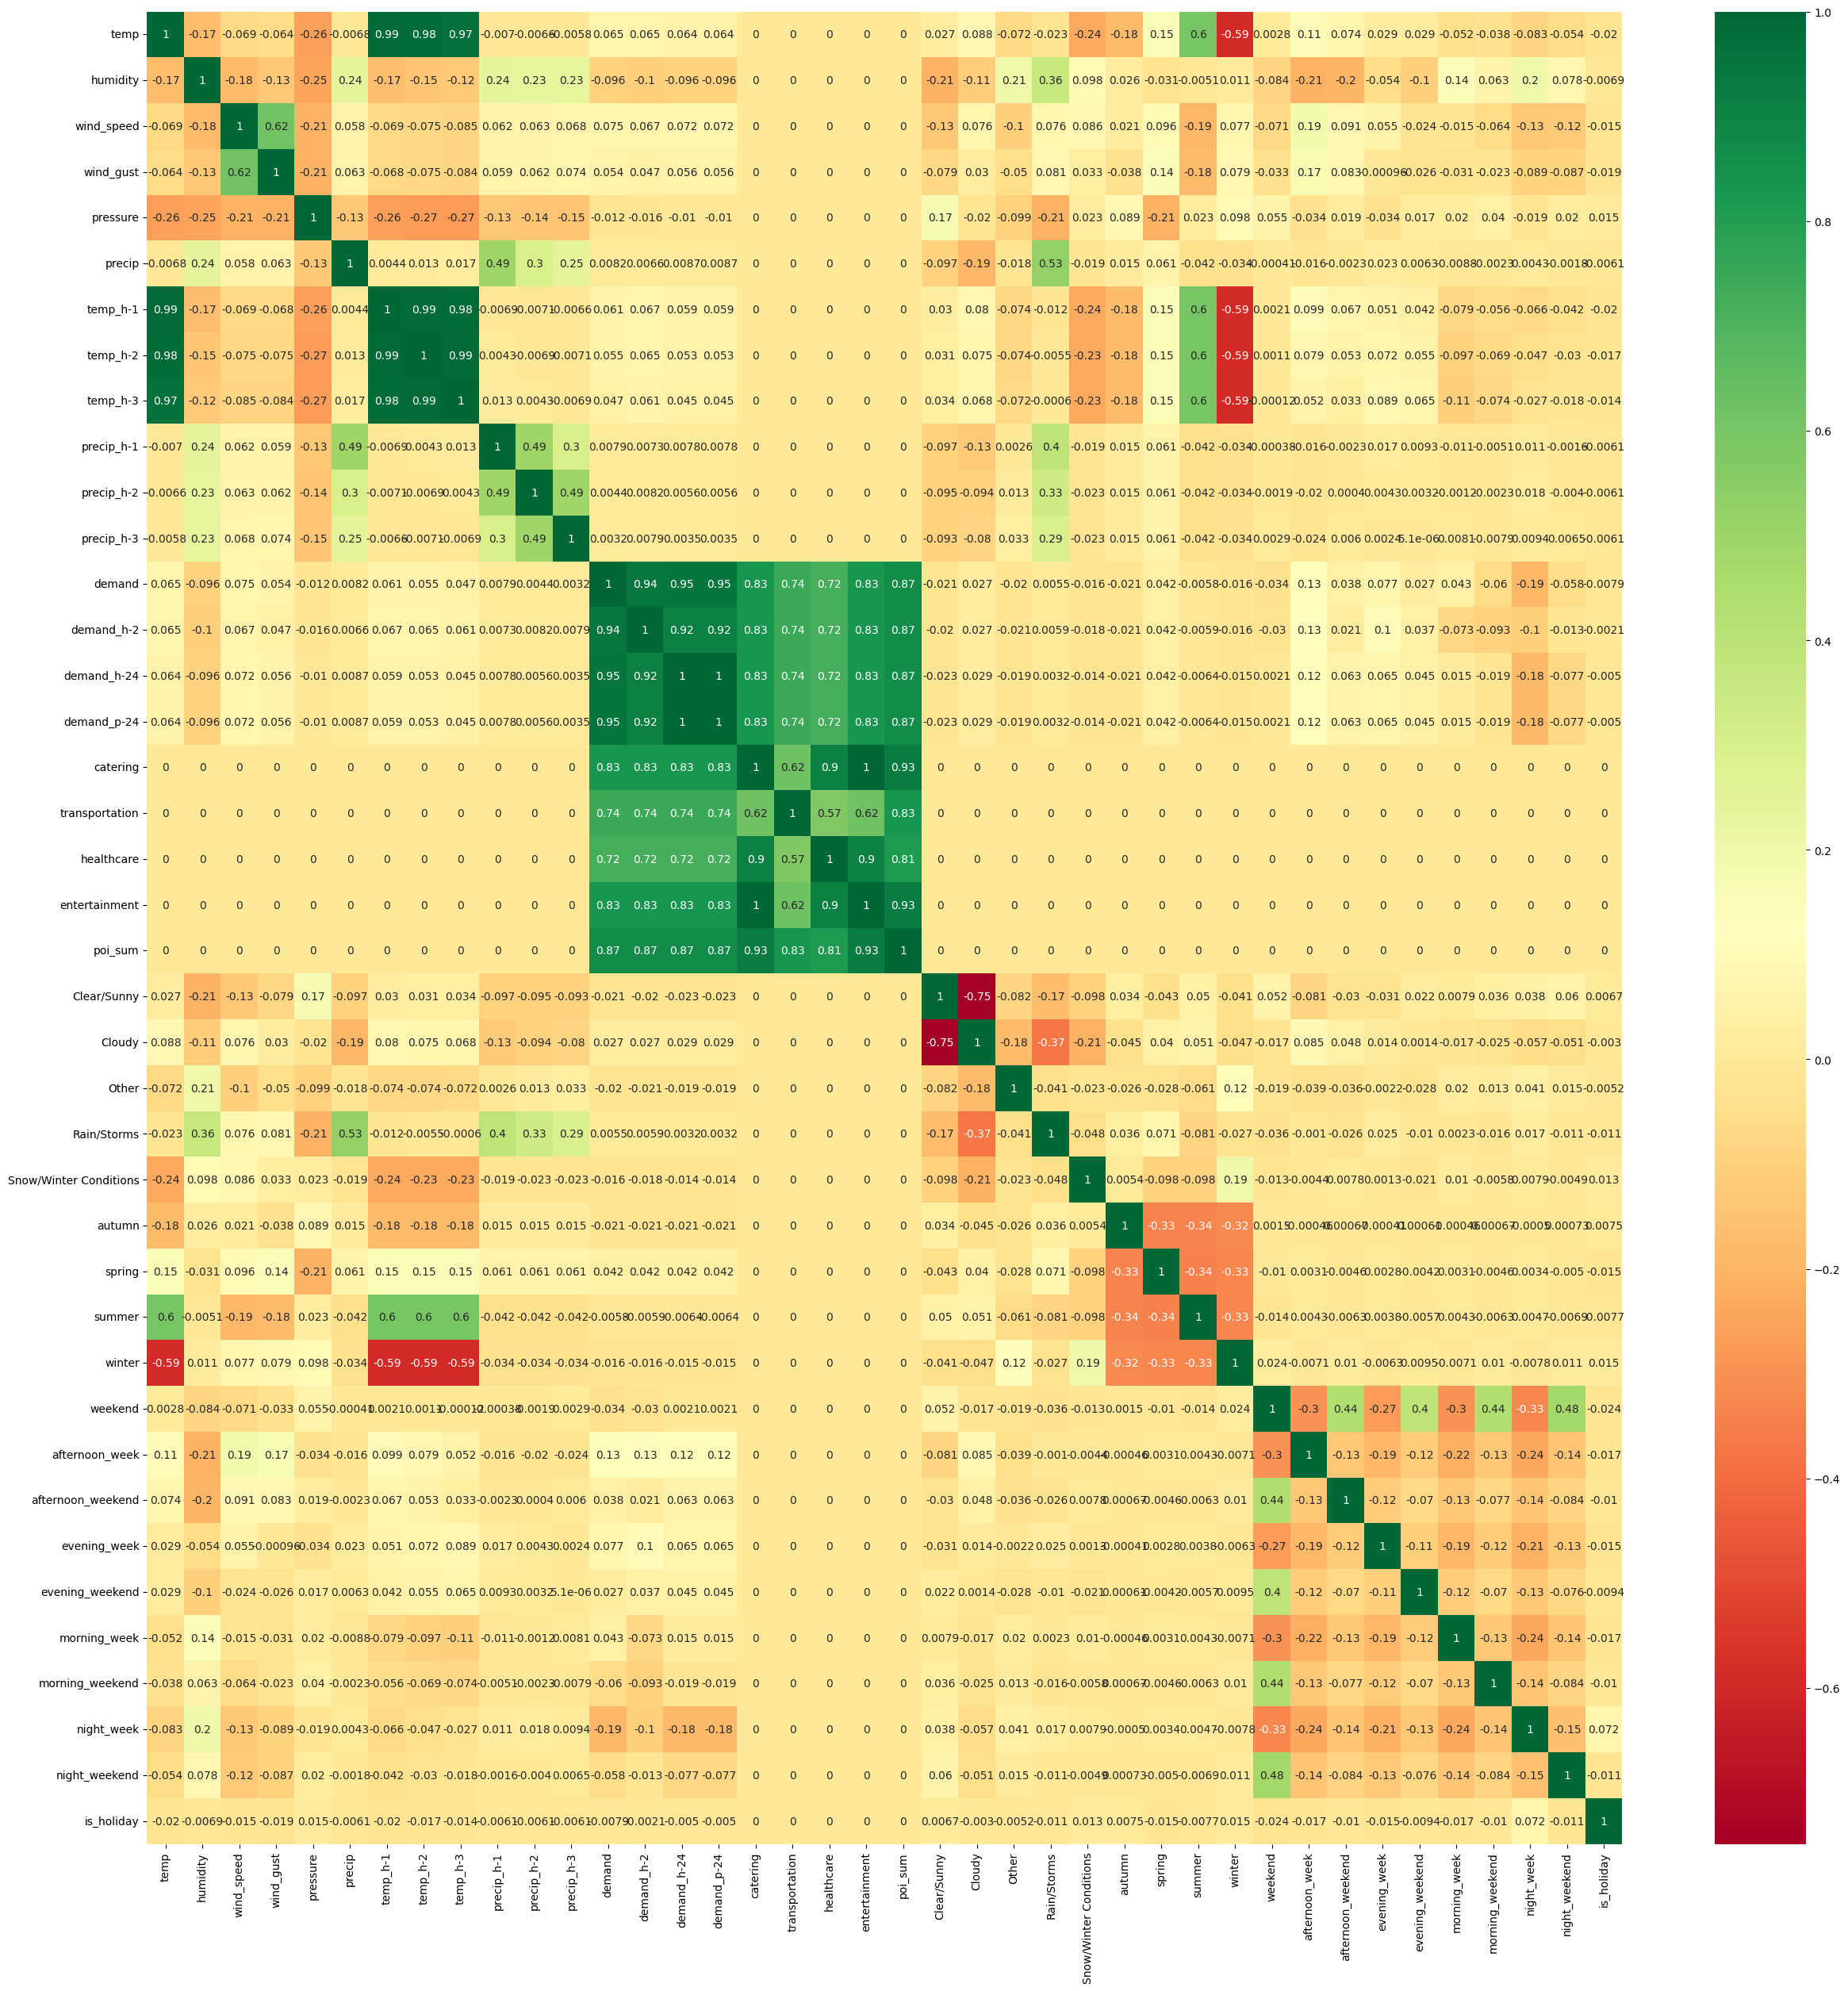

In [ ]:

plt.figure(figsize=(30, 30))

sns.heatmap(df_res_5[metric + nominal].corr(method="spearman"), annot=True, cmap="RdYlGn")

<Axes: >

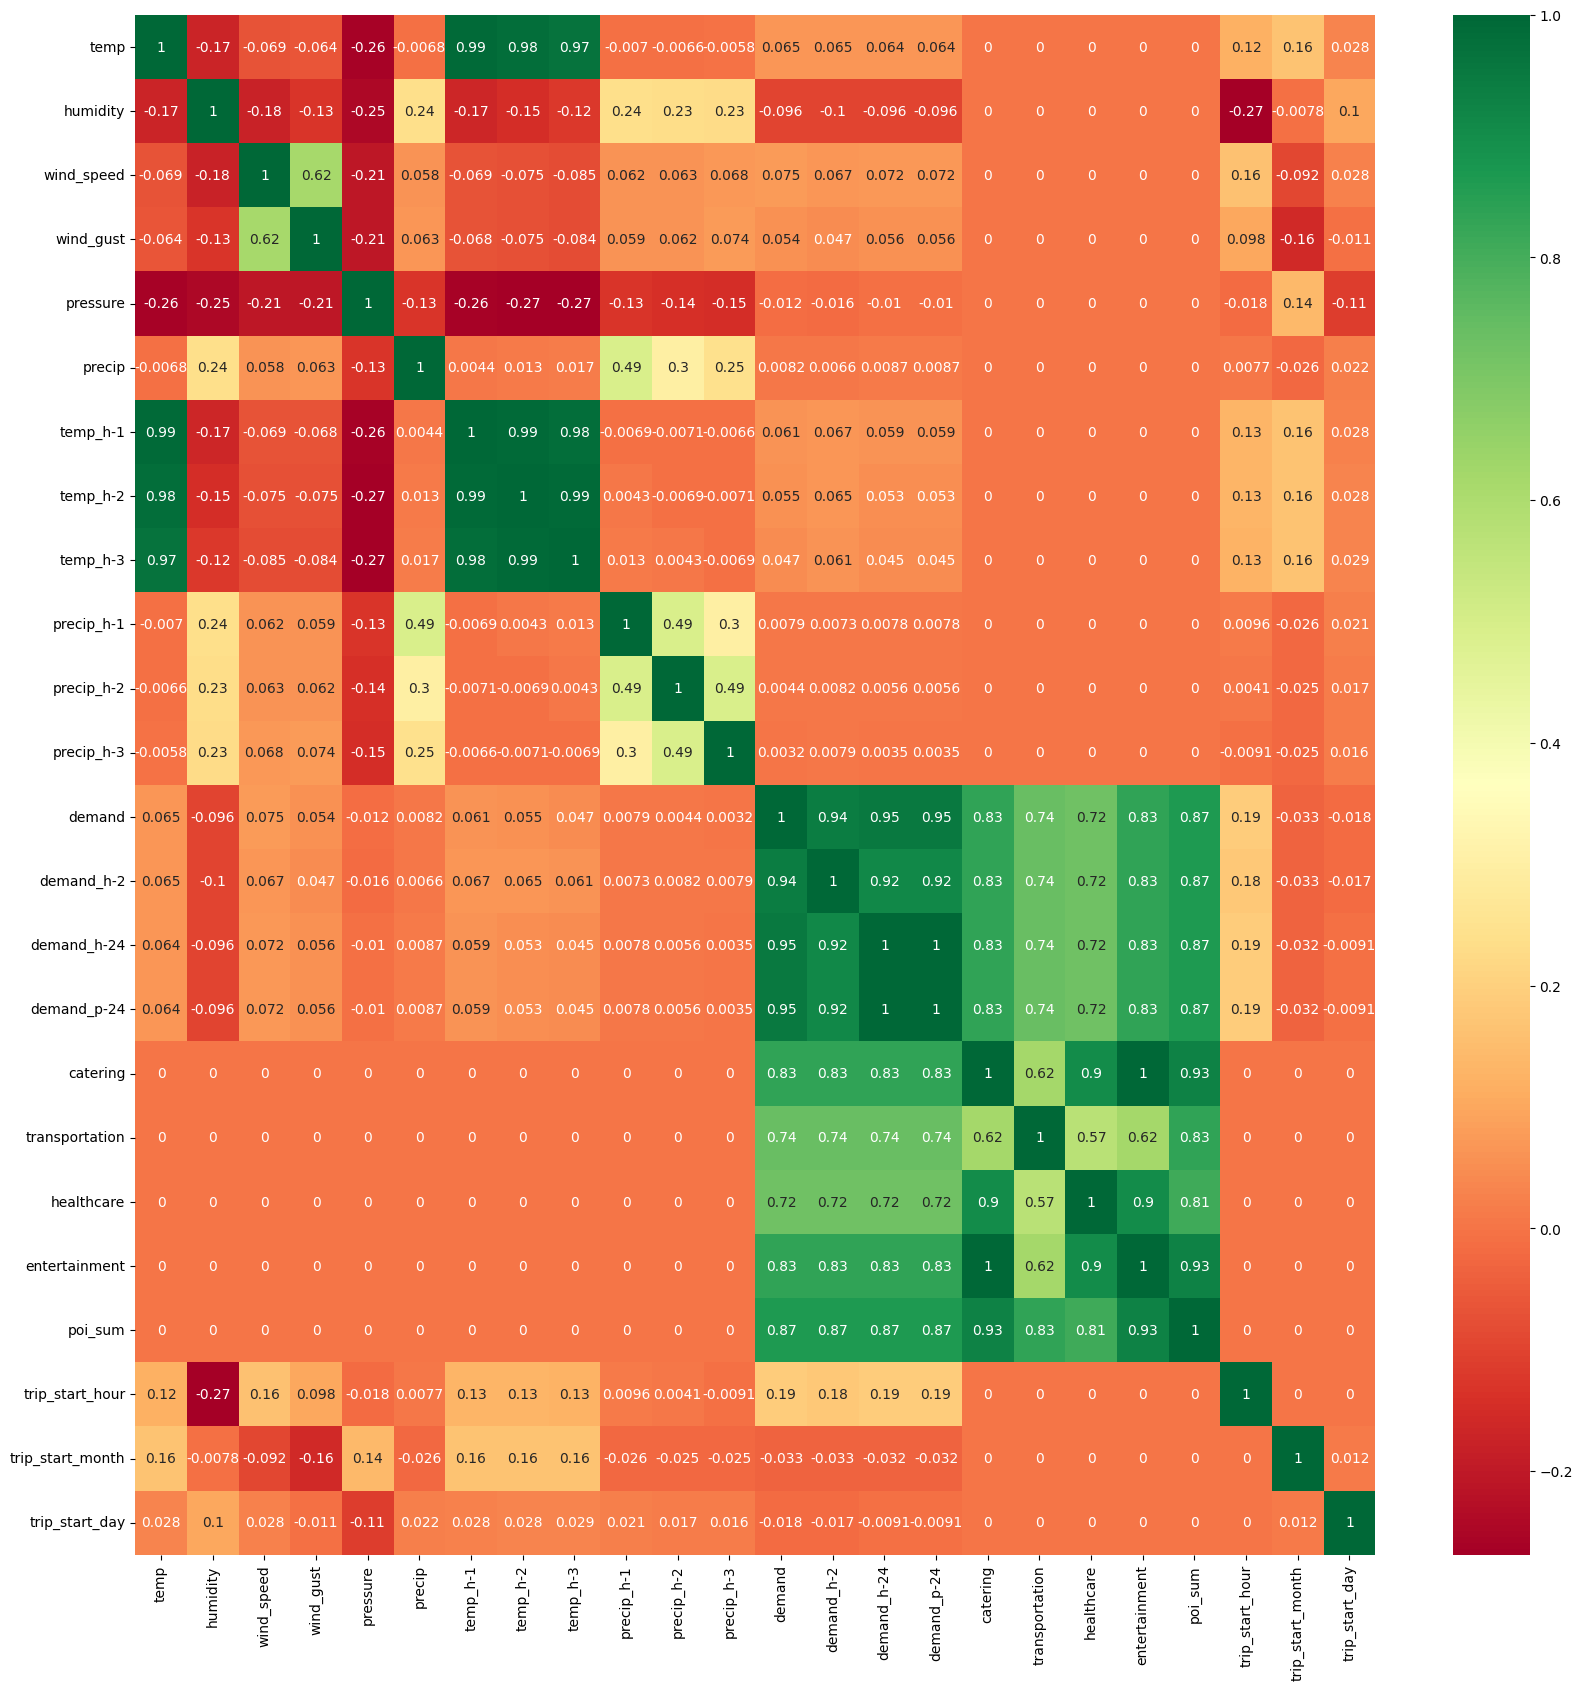

In [ ]:

plt.figure(figsize=(20, 20))

sns.heatmap(df_res_5[metric + ordinal].corr(method="spearman"), annot=True, cmap="RdYlGn")

# Dataset Export

## K-Fold Target encoding
With `pickup_loc` we still have a categorical feature in the dataset. As we we have more than 500 census tracts it does not make sense to do One hot encoding as we would obtain sparse data. Hence, we do k-fold target encoding with scikit-learn, which essentially uses a weighted sum of the mean of the target of each `pickup_loc` instead of the categorical `pickup_loc` value and the global mean. As this leads to leakage, we do this in combination with 5-fold cross fitting, as described under https://scikit-learn.org/stable/modules/preprocessing.html#target-encoder. This minimizes the impact of leakage and risk of overfitting. We fit the encoder only on the training data and apply the learnt transformation also to the test set, such that we have a consistent encoding.

In [ ]:
def encode_pickup(df_train, df_test, target, encoding_name):
    encoder = TargetEncoder(target_type='continuous', cv=5, smooth='auto')
    encoder.fit(df_train['pickup_loc'].values.reshape(-1,1), df_train[target].values.reshape(-1,))
    df_train[encoding_name] = encoder.transform(df_train['pickup_loc'].values.reshape(-1,1))
    df_test[encoding_name] = encoder.transform(df_test['pickup_loc'].values.reshape(-1,1))
    return df_train, df_test

## Split the dataset
We split the data into train and test set by an 80/20 ratio. We randomly shuffle the data. Although we have time series data, we do not keep it in temporal order, as we use past demand features with a rolling approach, as explained here: https://datascience.stackexchange.com/questions/54237/is-it-valid-to-shuffle-time-series-data-for-a-prediction-task

In [ ]:
def split_data(df):
    train_df, test_df = train_test_split(df, train_ratio=0.8, shuffle=True)
    return train_df, test_df

## Export Datasets

Now we export 10 datasets in total, i.e. datasets for resolutions 1-9 and one dataset for the census tract spatial unit.

In [ ]:
# For hexagons
for resolution in list(range(1, 10)):
    print(f"Processing resolution: {resolution}")
    df = get_prepared_data(location_type_hexagon=True, resolution=resolution)
    train_df, test_df = split_data(df)
    
    for target in ['demand_target_bucket_1', 'demand_target_bucket_2', 'demand_target_bucket_6', 'demand_target_bucket_24']:
        train_df, test_df = encode_pickup(train_df, test_df, target, f'pickup_{target}')
    train_df.to_csv(f'./data/model_input/{resolution}_res_train.csv', index=False)
    test_df.to_csv(f'./data/model_input/{resolution}_res_test.csv', index=False)
    print(f"Resolution {resolution} data saved.")

# Now for census tract
print("Processing census tract data.")
df = get_prepared_data(location_type_hexagon=False)
train_df, test_df = split_data(df)
for target in ['demand_target_bucket_1', 'demand_target_bucket_2', 'demand_target_bucket_6', 'demand_target_bucket_24']:
    train_df, test_df = encode_pickup(train_df, test_df, target, f'pickup_{target}')
train_df.to_csv(f'./data/model_input/0_res_train.csv', index=False)
test_df.to_csv(f'./data/model_input/0_res_test.csv', index=False)
print("Census tract data saved.")


Processing resolution: 1


KeyboardInterrupt: 